# Module 12: Maps

Let's draw some maps. 🗺🧐

## A dotmap with Altair

Let's start with altair. 

In [134]:
import altair as alt

# saving data into a file rather than embedding into the chart
alt.data_transformers.enable('json') 
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

Maybe we need a dataset with geographical coordinates. This `zipcodes` dataset contains the location and zipcode of each zip code area. 

In [135]:
from vega_datasets import data

zipcodes_url = data.zipcodes.url
zipcodes = data.zipcodes()
zipcodes.head()

,zip_code,latitude,longitude,city,state,county
0,00501,40.922326,-72.637078,Holtsville,NY,Suffolk
1,00544,40.922326,-72.637078,Holtsville,NY,Suffolk
2,00601,18.165273,-66.722583,Adjuntas,PR,Adjuntas
3,00602,18.393103,-67.180953,Aguada,PR,Aguada
4,00603,18.455913,-67.145780,Aguadilla,PR,Aguadilla


In [136]:
zipcodes = data.zipcodes(dtype={'zip_code': 'category'})
zipcodes.head()

,zip_code,latitude,longitude,city,state,county
0,00501,40.922326,-72.637078,Holtsville,NY,Suffolk
1,00544,40.922326,-72.637078,Holtsville,NY,Suffolk
2,00601,18.165273,-66.722583,Adjuntas,PR,Adjuntas
3,00602,18.393103,-67.180953,Aguada,PR,Aguada
4,00603,18.455913,-67.145780,Aguadilla,PR,Aguadilla


In [137]:
zipcodes.zip_code.dtype

CategoricalDtype(categories=['00501', '00544', '00601', '00602', '00603', '00604',
                  '00605', '00606', '00610', '00611',
                  ...
                  '99919', '99921', '99922', '99923', '99925', '99926',
                  '99927', '99928', '99929', '99950'],
                 ordered=False)

Btw, you'll have fewer issues if you pass URL instead of a dataframe to `alt.Chart`. 

### Let's draw it

Now we have the dataset loaded and start drawing some plots. Let's say you don't know anything about map projections. What would you try with geographical data? The simplest thing is probably considering (longitude, latitude) as a Cartesian coordinate and directly plot them. 

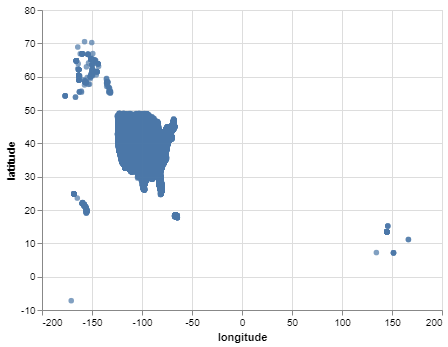

In [138]:
alt.Chart(zipcodes_url).mark_circle().encode(
    x='longitude:Q',
    y='latitude:Q',
)

Actually this itself is a map projection called [Equirectangular projection](https://en.wikipedia.org/wiki/Equirectangular_projection). This projection (or almost a *non-projection*) is super straight-forward and doesn't require any processing of the data. So, often it is used to just quickly explore geographical data. As you dig deeper, you still want to think about which map projection fits your need best. Don't just use equirectangular projection without any thoughts! 

Anyway, let's make it look slighly better by reducing the size of the circles and adjusting the aspect ratio. 

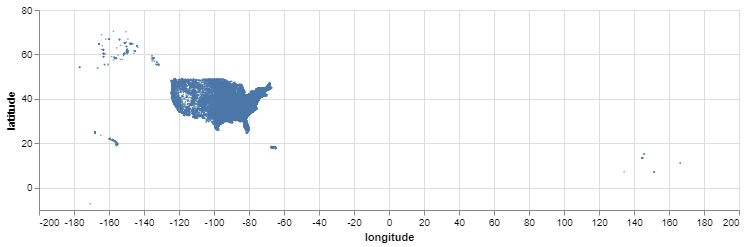

In [139]:
alt.Chart(zipcodes_url).mark_circle(size=2).encode(
    x='longitude:Q',
    y='latitude:Q',
).properties(
    width=700,
    height=200,
)

But, a much better way to do this is explicitly specifying that they are lat, lng coordinates by using `longitude=` and `latitude=`, rather than `x=` and `y=`. If you do that, altair automatically adjust the aspect ratio. Try to change the width and height. 

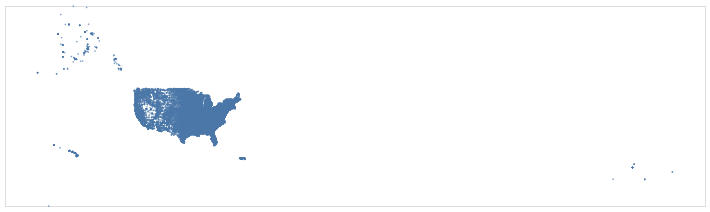

In [140]:
alt.Chart(zipcodes_url).mark_circle(size=2).encode(
    longitude='longitude:Q',
    latitude='latitude:Q',
).properties(
    width=700,
    height=200,
)

Because the [American empire is far-reaching and complicated](https://www.youtube.com/watch?v=ASSOQDQvVLU), the information density of this map is very low (although interesting). A common projection for visualizing US data is [AlbersUSA](https://bl.ocks.org/mbostock/5545680), which uses [Albers (equal-area) projection](https://en.wikipedia.org/wiki/Albers_projection). This is a standard projection used in United States Geological Survey and the United States Census Bureau. Albers USA is simply a composition of US main land, Alaska, and Hawaii. 

To use it, we simply call `project` method and specify which variables are `longitude` and `latitude`. 

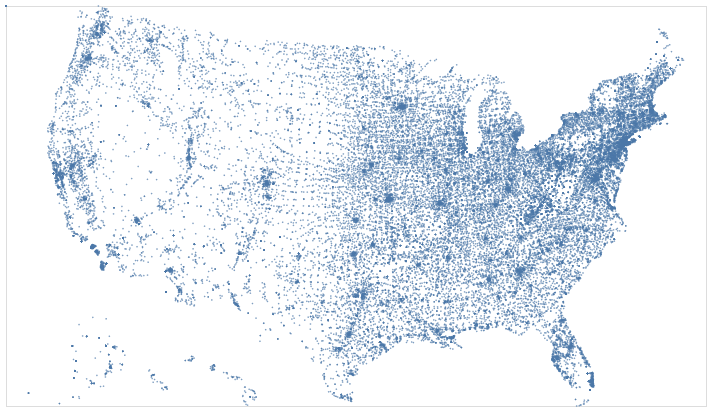

In [141]:
alt.Chart(zipcodes_url).mark_circle(size=2).encode(
    longitude='longitude:Q',
    latitude='latitude:Q',
).project(
    type='albersUsa'
).properties(
    width=700,
    height=400,
)

Can we see the large-scale division of the zipcodes? We can use the fact that the zipcodes are hierarchically organized. That is, the first digit captures the largest area divisions. 

Altair provides some data transformation functionalities. One of them is extracting a substring from a variable. 

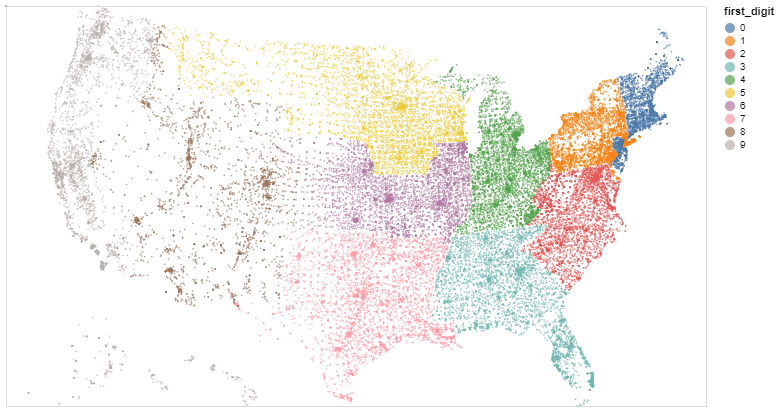

In [142]:
from altair.expr import datum, substring

alt.Chart(zipcodes_url).mark_circle(size=2).transform_calculate(
    'first_digit', substring(datum.zip_code, 0, 1)
).encode(
    longitude='longitude:Q',
    latitude='latitude:Q',
    color='first_digit:N',
).project(
    type='albersUsa'
).properties(
    width=700,
    height=400,
)

For each row (`datum`), you obtain the `zip_code` variable and get the substring (imagine Python list slicing), and then you call the result `first_digit`. Now, you can use this `first_digit` variable to color the circles. Also note that we specify `first_digit` as a *nominal* variable, not quantitative, to obtain a categorical colormap. But we can also play with it too. 

**Q: Why don't you extract the first two digits, name it as `two_digits`, and declare that as a quantitative variable? Any interesting patterns?** 

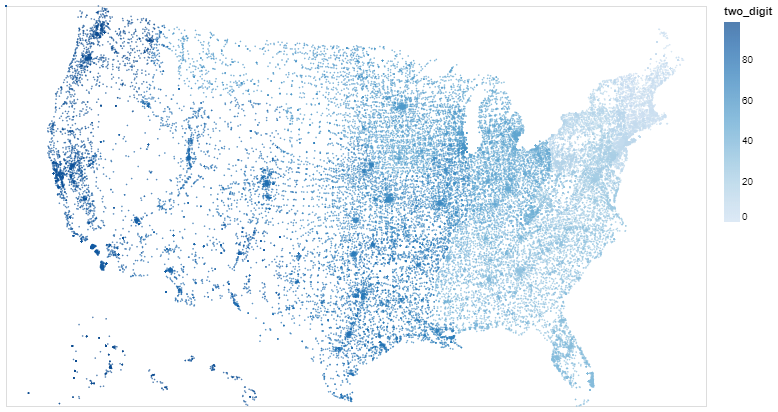

In [143]:
# Implement
from altair.expr import datum, substring

alt.Chart(zipcodes_url).mark_circle(size=2).transform_calculate(
    'two_digit', substring(datum.zip_code, 0, 2)
).encode(
    longitude='longitude:Q',
    latitude='latitude:Q',
    color='two_digit:Q',
).project(
    type='albersUsa'
).properties(
    width=700,
    height=400,
)

Btw, we can also put a tooltip. Also, you can always click "view source" or "open in Vega Editor" to look at the json object that **defines** this visualization. You can embed this json object on your webpage and easily put up an interactive visualization. 

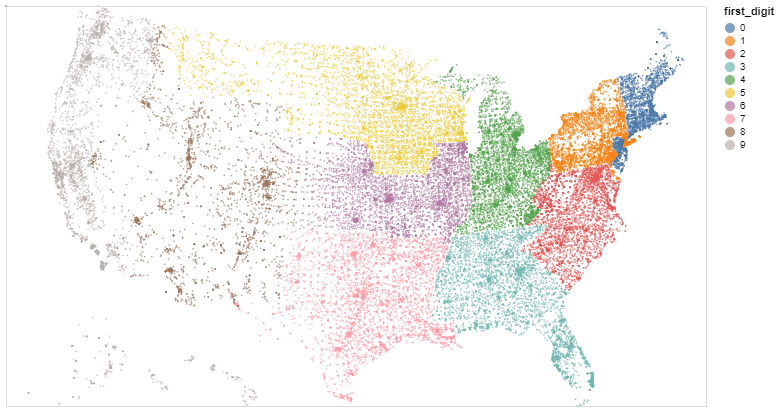

In [144]:
alt.Chart(zipcodes_url).mark_circle(size=2).transform_calculate(
    'first_digit', substring(datum.zip_code, 0, 1)
).encode(
    longitude='longitude:Q',
    latitude='latitude:Q',
    color='first_digit:N',
    tooltip='zip_code:N'
).project(
    type='albersUsa'
).properties(
    width=700,
    height=400,
)

## Choropleth 

Let's try some choropleth now. Vega datasets have US county / state boundary data (`us_10m`) and world country boundary data (`world-110m`). You can take a look at the boundaries on GitHub (they renders topoJSON files):

- https://github.com/vega/vega-datasets/blob/gh-pages/data/us-10m.json
- https://github.com/vega/vega-datasets/blob/gh-pages/data/world-110m.json

If you click "Raw" then you can take a look at the actual file, which is hard to read. 

Essentially, each file is a large dictionary with the following keys. 

In [145]:
usmap = data.us_10m()
usmap.keys()

dict_keys(['type', 'transform', 'objects', 'arcs'])

In [146]:
usmap['type']

'Topology'

In [147]:
usmap['transform']

{'scale': [0.003589294092944858, 0.0005371535195261037],
 'translate': [-179.1473400003406, 17.67439566600018]}

This `transformation` is used to *quantize* the data and store the coordinates in integer (easier to store than float type numbers). 

https://github.com/topojson/topojson-specification#212-transforms

In [148]:
usmap['objects'].keys()

dict_keys(['counties', 'states', 'land'])

This data contains not only county-level boundaries (objects) but also states and land boundaries. 

In [149]:
usmap['objects']['land']['type'], usmap['objects']['states']['type'], usmap['objects']['counties']['type']

('MultiPolygon', 'GeometryCollection', 'GeometryCollection')

`land` is a multipolygon (one object) and `states` and `counties` contains many geometrics (multipolygons) because there are many states (counties). We can look at a state as a set of arcs that define it. It's `id` captures the identity of the state and is the key to link to other datasets. 

In [150]:
state1 = usmap['objects']['states']['geometries'][1]
state1

{'type': 'MultiPolygon',
 'arcs': [[[10337]],
  [[10342]],
  [[10341]],
  [[10343]],
  [[10834, 10340]],
  [[10344]],
  [[10345]],
  [[10338]]],
 'id': 15}

The `arcs` referred here is defined in `usmap['arcs']`. 

In [151]:
usmap['arcs'][:10]

[[[15739, 57220], [0, 0]],
 [[15739, 57220], [29, 62], [47, -273]],
 [[15815, 57009], [-6, -86]],
 [[15809, 56923], [0, 0]],
 [[15809, 56923], [-36, -8], [6, -210], [32, 178]],
 [[15811, 56883], [9, -194], [44, -176], [-29, -151], [-24, -319]],
 [[15811, 56043], [-12, -216], [26, -171]],
 [[15825, 55656], [-2, 1]],
 [[15823, 55657], [-19, 10], [26, -424], [-26, -52]],
 [[15804, 55191], [-30, -72], [-47, -344]]]

It seems pretty daunting to work with this dataset, right? But fortunately people have already built tools to handle such data. 

In [152]:
states = alt.topo_feature(data.us_10m.url, 'states')

In [153]:
states

UrlData({
  format: TopoDataFormat({
    feature: 'states',
    type: 'topojson'
  }),
  url: 'https://vega.github.io/vega-datasets/data/us-10m.json'
})

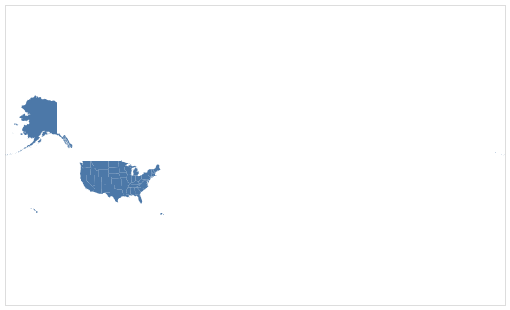

In [154]:
alt.Chart(states).mark_geoshape().properties(
    width=500,
    height=300
)

We have a map of US states. :) Can you use AlbersUSA projection on this? 

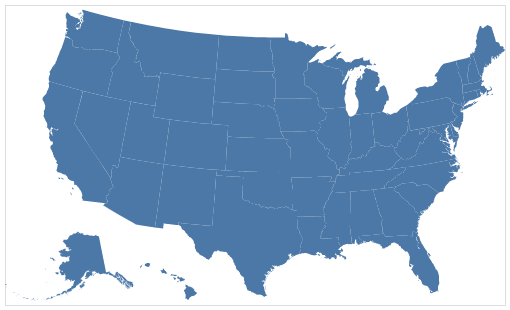

In [155]:
# Implement
alt.Chart(states).mark_geoshape(
).project(
    type='albersUsa'
).properties(
    width=500,
    height=300
)


Can you do the same thing with counties and draw county boundaries?

In [156]:
# Implement
us_counties = alt.topo_feature(data.us_10m.url, 'counties')

In [157]:
us_counties

UrlData({
  format: TopoDataFormat({
    feature: 'counties',
    type: 'topojson'
  }),
  url: 'https://vega.github.io/vega-datasets/data/us-10m.json'
})

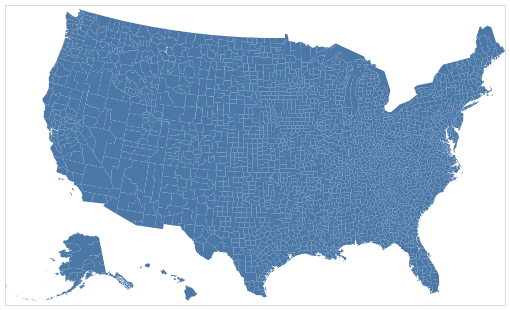

In [158]:
# Implement
alt.Chart(us_counties).mark_geoshape(
).project(
    type='albersUsa'
).properties(
    width=500,
    height=300
)

Let's load some county-level unemployment data. 

In [159]:
unemp_data = data.unemployment(sep='\t')
unemp_data.head()

,id,rate
0,1001,0.097
1,1003,0.091
2,1005,0.134
3,1007,0.121
4,1009,0.099


This dataset has unemployment rate. When? I don't know. We don't care about data provenance here because the goal is quickly trying out choropleth. But if you're working with a real dataset, you should be very sensitive about the provenance of your dataset. Make sure you understand where the data came from and how it was processed. 

Anyway, for each county specified with `id`. To combine two datasets, we use "Lookup transform" - https://vega.github.io/vega/docs/transforms/lookup/. Essentially, we use the `id` in the map data to look up (again) `id` field in the `unemp_data` and then bring in the `rate` variable. Then, we can use that `rate` variable to encode the color of the `geoshape` mark. 

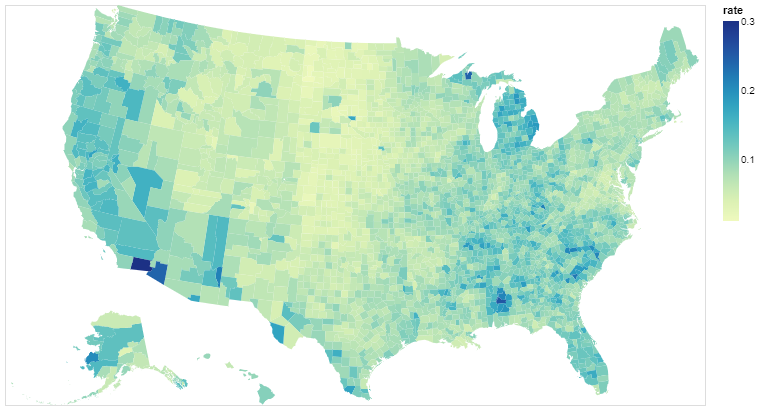

In [160]:
alt.Chart(us_counties).mark_geoshape().project(
    type='albersUsa'
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(unemp_data, 'id', ['rate'])
).encode(
    color='rate:Q'
).properties(
    width=700,
    height=400
)

There you have it, a basic choropleth map. 😎 


## Raster visualization with datashader

Although many geovisualizations use vector graphics, raster visualization is still useful especially when you deal with images and lots of datapoints. Datashader is a package that aggregates and visualizes a large amount of data very quickly. Given a *scene* (visualization boundary, resolution, etc.), it quickly aggregate the data and produce **pixels** and send them to you. 

To appreciate its power, we need a fairly large dataset. Let's use NYC taxi trip dataset on Kaggle: https://www.kaggle.com/kentonnlp/2014-new-york-city-taxi-trips You can download even bigger trip data from NYC open data website: https://opendata.cityofnewyork.us/data/

Ah, and you want to install the datashader, bokeh, and holoviews first if you don't have them yet.  

    pip install datashader bokeh holoviews

or 

    conda install datashader bokeh holoviews
    

In [161]:
import pandas as pd
import datashader as ds
from datashader import transfer_functions as tf
from colorcet import fire

Because the dataset is pretty big, let's use a small sample first. For this visualization, we only keep the dropoff location. 

In [162]:
nyctaxi = pd.read_csv('C:\\Users\\sures\\Downloads\\2014-new-york-city-taxi-trips\\nyc_taxi_data_2014.csv', nrows=10000, usecols=['dropoff_longitude', 'dropoff_latitude'])
nyctaxi.head()

,dropoff_longitude,dropoff_latitude
0,-73.982227,40.731790
1,-73.960449,40.763995
2,-73.986626,40.765217
3,-73.979863,40.777050
4,-73.984367,40.720524


Although the dataset is different, we can still follow the example here: http://datashader.org/getting_started/1_Introduction.html

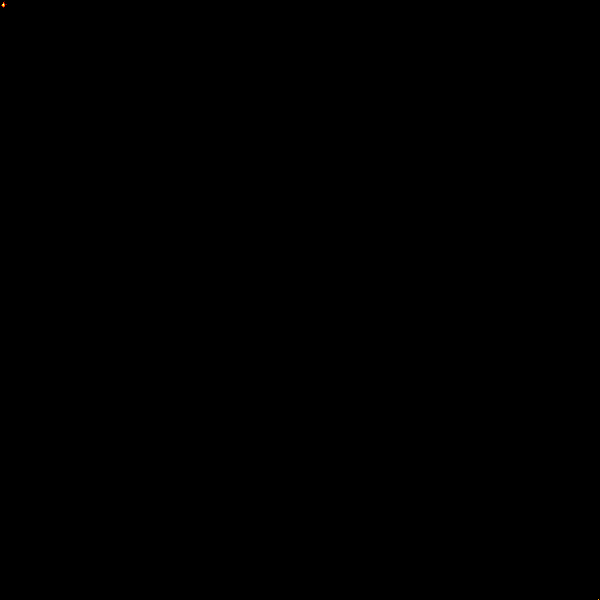

In [163]:
agg = ds.Canvas().points(nyctaxi, 'dropoff_longitude', 'dropoff_latitude')
tf.set_background(tf.shade(agg, cmap=fire),"black")

Why can't we see anything? Wait, do you see the small dots on the left top? Can that be New York City? Maybe we don't see anything because some people travel very far? or because the dataset has some missing data?

In [164]:
nyctaxi.isna().sum()

dropoff_longitude    1
dropoff_latitude     1
dtype: int64

In [165]:
nyctaxi.dropna(inplace=True)

Now there's no NaN in the data. let's try histogram. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001BB51E30438>,
      dtype=object)

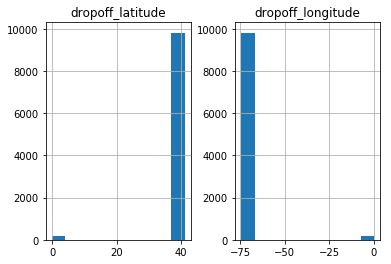

In [166]:
%matplotlib inline
nyctaxi.hist()

Ah, there seems to be some outliers, which look like zero. Because lat lng should vary within a very small range, let's filter the data.  

In [167]:
df = nyctaxi[nyctaxi['dropoff_latitude'].between(40.5, 41) & nyctaxi['dropoff_longitude'].between(-74.1, -73.7)]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001BB5204B748>,
      dtype=object)

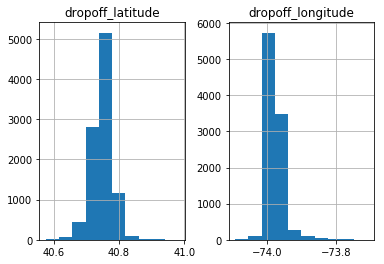

In [168]:
df.hist()

Now the histograms look pretty reasonable. 

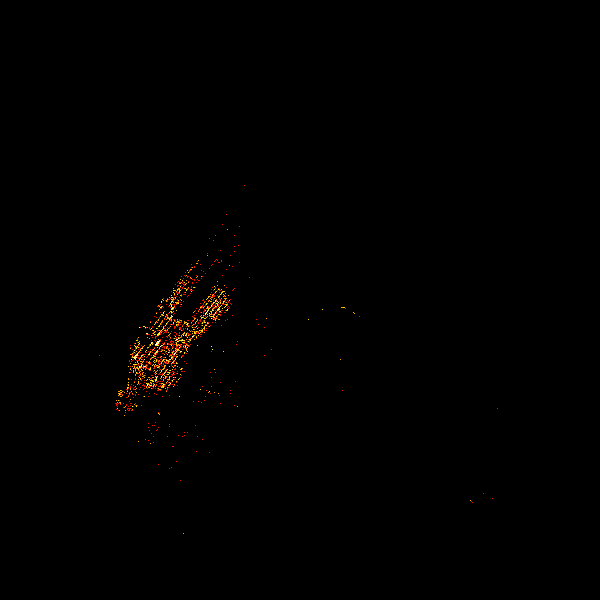

In [169]:
agg = ds.Canvas().points(df, 'dropoff_longitude', 'dropoff_latitude')
tf.set_background(tf.shade(agg, cmap=fire), "black")

Do you see the black empty space at the center? That looks like the Central Park. This is cool, but it'll be awesome if we can explore the data interactively. 

Ok, now let's get serious by loading the whole dataset. It may take some time. Drop NaN rows, and filter using the latitude and longitude range that we used, and then feed the data into the datashader. 

In [172]:
# Implement 
nyctaxi_full = pd.read_csv('C:\\Users\\sures\\Downloads\\2014-new-york-city-taxi-trips\\nyc_taxi_data_2014.csv', error_bad_lines = False)
nyctaxi_full.head()

C:\Users\sures\New_folder\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,CMT,2014-01-09 20:45:25,2014-01-09 20:52:31,1,0.7,-73.994770,40.736828,1,N,-73.982227,40.731790,CRD,6.5,0.5,0.5,1.40,0.0,8.90
1,CMT,2014-01-09 20:46:12,2014-01-09 20:55:12,1,1.4,-73.982392,40.773382,1,N,-73.960449,40.763995,CRD,8.5,0.5,0.5,1.90,0.0,11.40
2,CMT,2014-01-09 20:44:47,2014-01-09 20:59:46,2,2.3,-73.988570,40.739406,1,N,-73.986626,40.765217,CRD,11.5,0.5,0.5,1.50,0.0,14.00
3,CMT,2014-01-09 20:44:57,2014-01-09 20:51:40,1,1.7,-73.960213,40.770464,1,N,-73.979863,40.777050,CRD,7.5,0.5,0.5,1.70,0.0,10.20
4,CMT,2014-01-09 20:47:09,2014-01-09 20:53:32,1,0.9,-73.995371,40.717248,1,N,-73.984367,40.720524,CRD,6.0,0.5,0.5,1.75,0.0,8.75


In [173]:
len(nyctaxi_full)

14999999

In [174]:
nyctaxi_full.dropna(inplace=True)

In [175]:
nyctaxi_full.isna().sum()

vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
trip_distance         0
pickup_longitude      0
pickup_latitude       0
rate_code             0
store_and_fwd_flag    0
dropoff_longitude     0
dropoff_latitude      0
payment_type          0
fare_amount           0
surcharge             0
mta_tax               0
tip_amount            0
tolls_amount          0
total_amount          0
dtype: int64

In [176]:
df_full = nyctaxi_full.loc[nyctaxi_full['dropoff_latitude'].between(40.5, 41) & nyctaxi_full['dropoff_longitude'].between(-74.1, -73.7)]

In [177]:
df_full.isna().sum()

vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
trip_distance         0
pickup_longitude      0
pickup_latitude       0
rate_code             0
store_and_fwd_flag    0
dropoff_longitude     0
dropoff_latitude      0
payment_type          0
fare_amount           0
surcharge             0
mta_tax               0
tip_amount            0
tolls_amount          0
total_amount          0
dtype: int64

Can you feed the data directly to datashader to reproduce the static plot, this time with the full data?

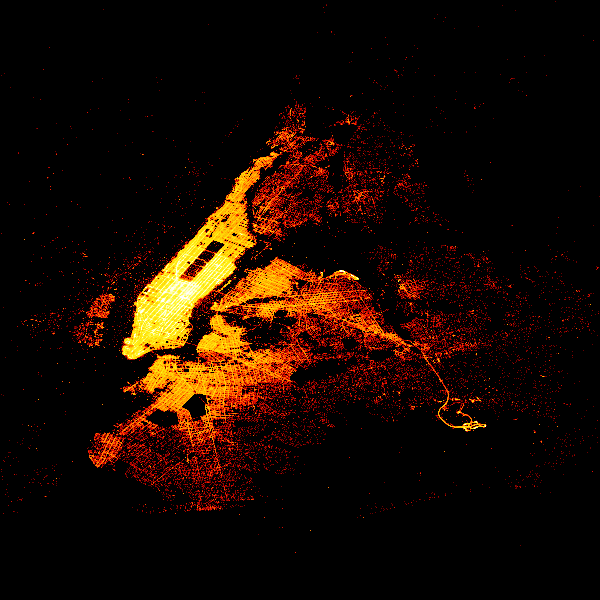

In [178]:
# Implement
agg_new = ds.Canvas().points(df_full, 'dropoff_longitude', 'dropoff_latitude')
tf.set_background(tf.shade(agg_new, cmap=fire), "black")

Wow, that's fast. Also it looks cool! 

**Q: how many rows (data points) are we visualizing right now?**

In [179]:
# figure it out
len(df_full)

7204489

We're working with ?? rows (points) right now. Yet, datashader + holoviews + bokeh renders everything almost in real time! 

## map overlays

Another useful types of visualization is overlaying data on an explorable map (Google maps, Open streetmap, ...). [Leaflet.js](https://leafletjs.com) is one of the easiest options to do that on the web, and there is a Python bridge of it: https://github.com/jupyter-widgets/ipyleaflet  Although we will not go into details, it's certainly something that's worth checking out if you're using geographical data. 